**$1^o$ ΕΡΓΑΣΤΗΡΙΑΚΟ PROJECT ΣΤΗΝ ΌΡΑΣΗ ΥΠΟΛΟΓΙΣΤΩΝ**

`Αραβανής Τηλέμαχος 03119024`

`Θεοδωρόπουλος Ηλίας 03119858` 

---

* Μέρος 1

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# 1.1.1 Load image I0 = “edgetest_23.png”

# Read grayscale image
I_0 = cv2.imread('edgetest_23.png', cv2.IMREAD_GRAYSCALE)

print("Image loaded as: ", type(I_0))

print("Resolution: ", I_0.shape)
print("Range: %d - %d " % (np.min(I_0), np.max(I_0)))

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (512, 512)
Range: 0 - 255 


In [3]:
# Normalize to [0,1]
I_0 = I_0.astype(float)/255

print("Range: %f - %f " % (np.min(I_0), np.max(I_0)))

Range: 0.000000 - 1.000000 


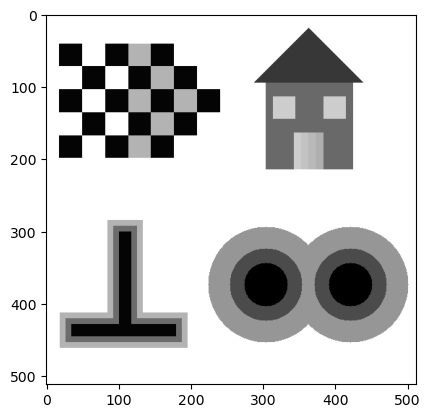

In [4]:
# Show image

plt.imshow(I_0, cmap='gray')
plt.show()

Range: 0.000000 - 1.000000 


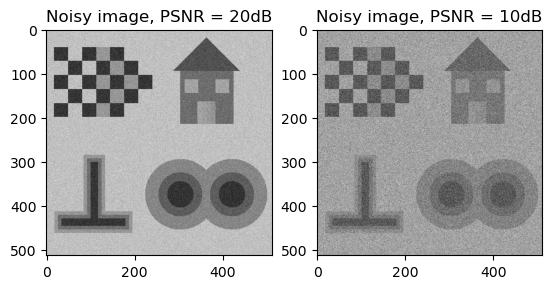

In [8]:
# 1.1.2 Create noisy image with appropriate PSNR

def Noisy_Img(Im, PSNR):
    sigma = (np.max(Im) - np.min(Im))*10**(-PSNR/20)
    
    Noise = np.random.normal(loc = 0.0, scale = sigma, size = (512,512)) # generate noisy array 512*512
    
    noisy_img = np.add(Im,Noise)
    
    noisy_img = noisy_img - np.min(noisy_img)
    noisy_img = noisy_img.astype(float)/np.max(noisy_img) # Normalize to [0,1]
    
    return noisy_img

I_0_20dB = Noisy_Img(I_0,20)
I_0_10dB = Noisy_Img(I_0,10)

print("Range: %f - %f " % (np.min(I_0_20dB), np.max(I_0_20dB)))

plt.subplot(1,2,1)
plt.imshow(I_0_20dB, cmap='gray')
plt.title("Noisy image, PSNR = 20dB")
plt.subplot(1,2,2)
plt.imshow(I_0_10dB, cmap='gray')
plt.title("Noisy image, PSNR = 10dB")
plt.savefig('fig1.jpg')
plt.show()

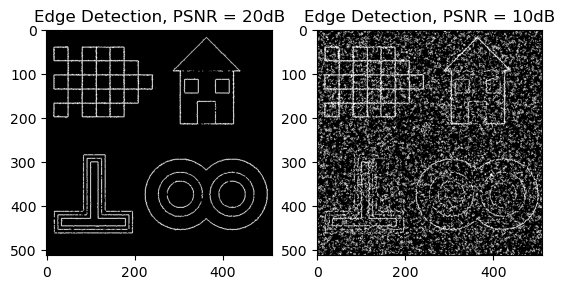

In [11]:
# 1.2 Implementation of EdgeDetect

def Gaussian_Filters(sigma):
    n = int(np.ceil(3*sigma)*2 + 1)
    
    Gaussian_1D = cv2.getGaussianKernel(n,sigma)
    Gaussian = Gaussian_1D @ Gaussian_1D.T
    
    n = np.linspace(-(n//2),n//2,n)
    
    x,y = np.meshgrid(n,n)
    
    # Gaussian_byHand = (1/(2*np.pi*np.square(sigma)))*np.exp(-(x**2 + y**2)/(2*sigma**2)) 
    LoG = ((x**2 + y**2 - 2*sigma**2)/(2*np.pi*sigma**6))*np.exp(-(x**2 + y**2)/(2**np.square(sigma))) 
    
    return Gaussian, LoG

    
def Edgedetect(Im,sigma,theta_edge,linear=1):
    Gaussian_kernel, LoG_kernel = Gaussian_Filters(sigma)
    B = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]]).astype(np.uint8)
    
    Im_smooth = cv2.filter2D(Im,-1,Gaussian_kernel)
    
    if linear == 1:
        Im_Laplacian = cv2.filter2D(Im,-1,LoG_kernel)
        # Im_Laplacian = cv2.Laplacian(Im,-1)
        
    else:
        Im_dilated = cv2.dilate(Im_smooth, B)
        Im_eroded = cv2.erode(Im_smooth, B)
        
        Im_Laplacian = Im_dilated + Im_eroded - 2*Im_smooth
        
    X = (Im_Laplacian >= 0).astype(np.uint8) 
    
    X_dilated = cv2.dilate(X, B)
    X_eroded = cv2.erode(X, B)
    Y = X_dilated - X_eroded
    
    Im_Grad = np.gradient(Im_smooth)
    
    Grad = np.sqrt(Im_Grad[0]**2 + Im_Grad[1]**2)
    
    Bool = (Grad >= theta_edge*np.max(Grad))
    
    D = (Y & Bool)
    
    return D

Edges_10dB_linear = Edgedetect(I_0_10dB,1,0.2,1) 
Edges_10dB_nonlinear = Edgedetect(I_0_10dB,1,0.2,0) 

Edges_20dB_linear = Edgedetect(I_0_20dB,1,0.2,1) 
Edges_20dB_nonlinear = Edgedetect(I_0_20dB,1,0.2,0) 

plt.subplot(1,2,1)
plt.imshow(Edges_20dB_linear, cmap='gray')
plt.title("Edge Detection, PSNR = 20dB")
plt.subplot(1,2,2)
plt.imshow(Edges_10dB_linear, cmap='gray')
plt.title("Edge Detection, PSNR = 10dB")
plt.savefig('fig2.jpg')
plt.show()

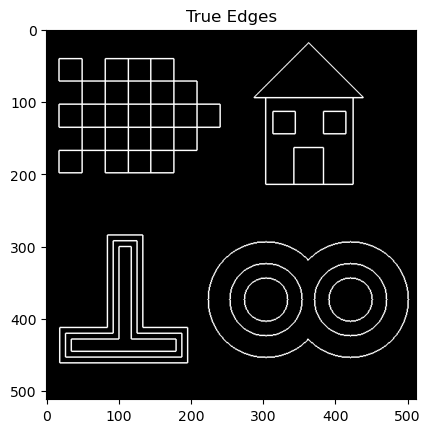

C:\Users\Admin\anaconda3\envs\cv_lab1_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in ulong_scalars


PSNR = 20dB, Best Params: sigma = 1.5 theta_edge 0.2 and non linear filters
C = 0.966451803838976


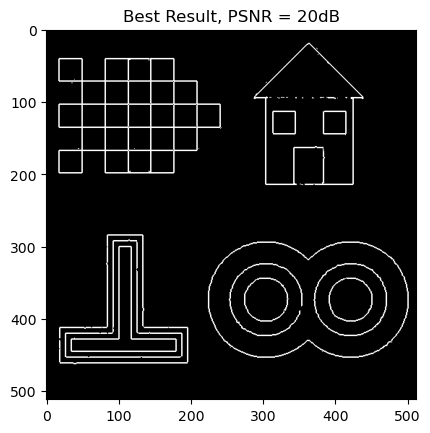

PSNR = 10dB, Best Params: sigma = 2.5 theta_edge 0.2 and non linear filters
C = 0.766673890794299


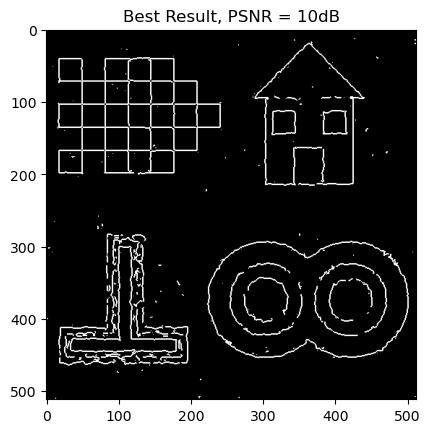

In [12]:
# 1.3 Evaluation of the edge detection results in the noisy image

def Real_Edges(Im,theta_realedge):

    B = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]]).astype(np.uint8)

    Im_dilated = cv2.dilate(Im, B)
    Im_eroded = cv2.erode(Im, B)

    M = Im_dilated - Im_eroded 

    T = (M > theta_realedge)
    
    return T

RealEdges = Real_Edges(I_0,0.1)

plt.imshow(RealEdges, cmap='gray')
plt.title("True Edges")
plt.savefig('fig3.jpg')
plt.show()

def Evaluation_Metric_Edge_Detection_C(RealEdges, Detected_Edges):
    detected_true_edges = np.sum(RealEdges & Detected_Edges)
    detected_edges = np.sum(Detected_Edges)
    true_edges = np.sum(RealEdges)

    C = (detected_true_edges/true_edges + detected_true_edges/detected_edges)/2
    
    return C

sigma =  [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
theta_edge = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
linear = [0,1]

C_20dB = C_10dB = 0.1
for s in sigma:
    for theta in theta_edge:
        for l in linear:
            Im_20dB = Edgedetect(I_0_20dB,s,theta,l)
            C_1 = Evaluation_Metric_Edge_Detection_C(RealEdges,Im_20dB)
            Im_10dB = Edgedetect(I_0_10dB,s,theta,l)
            C_2 = Evaluation_Metric_Edge_Detection_C(RealEdges,Im_10dB)
            if C_1 > C_20dB:
                C_20dB = C_1
                Best_20dB = (s,theta,l)
                Best_Im_20dB = Im_20dB
            if C_2 > C_10dB:
                C_10dB = C_2
                Best_10dB = (s,theta,l)
                Best_Im_10dB = Im_10dB

                
print("PSNR = 20dB, Best Params: sigma = " + str(Best_20dB[0]) + " theta_edge " + str(Best_20dB[1]) + " and non linear filters")
print("C = " + str(C_20dB))

plt.imshow(Best_Im_20dB, cmap='gray')
plt.title("Best Result, PSNR = 20dB")
plt.savefig('fig4.jpg')
plt.show()

print("PSNR = 10dB, Best Params: sigma = " + str(Best_10dB[0]) + " theta_edge " + str(Best_10dB[1]) + " and non linear filters")
print("C = " + str(C_10dB))

plt.imshow(Best_Im_10dB, cmap='gray')
plt.title("Best Result, PSNR = 10dB")
plt.savefig('fig5.jpg')
plt.show()

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (534, 800)
Range: 0.000000 - 1.000000 


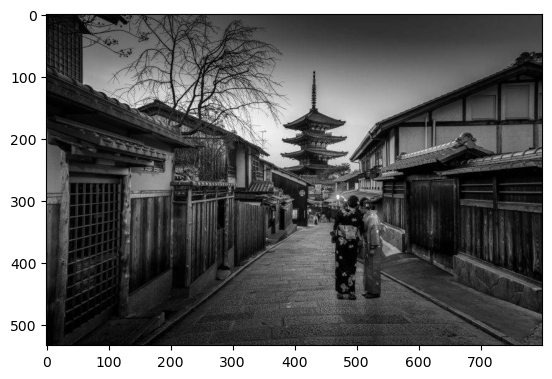

Best Params: sigma = 3 theta_edge 0.1 and non linear filters


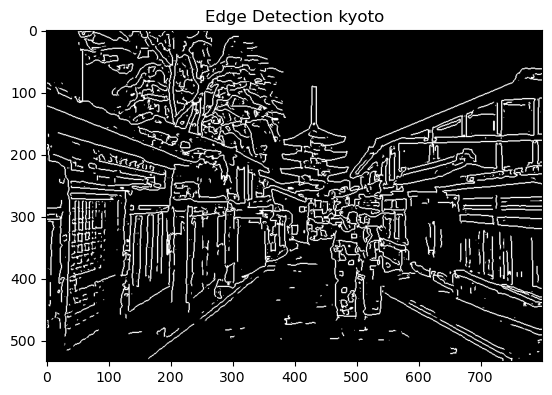

In [13]:
# 1.4 Edge detection in the real image “kyoto edges.jpg”

# Read grayscale image
I_1 = cv2.imread('kyoto_edges.jpg', cv2.IMREAD_GRAYSCALE)

print("Image loaded as: ", type(I_1))

print("Resolution: ", I_1.shape)

# Normalize to [0,1]
I_1 = I_1.astype(float)/255

print("Range: %f - %f " % (np.min(I_1), np.max(I_1)))

# Show image
plt.imshow(I_1, cmap='gray')
plt.show()

Edges_kyoto = Edgedetect(I_1,3,0.1,0)

print("Best Params: sigma = 3 theta_edge 0.1 and non linear filters")

plt.imshow(Edges_kyoto, cmap='gray')
plt.title("Edge Detection kyoto")
plt.savefig('fig6.jpg')
plt.show()

---

* Μέρος 2

In [15]:
# Given functions

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def interest_points_visualization(I_, kp_data_, ax=None):
    '''
    Plot keypoints chosen by detectors on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=1)
        ax.add_patch(circ)

    return ax

def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)


Range: 0.000000 - 1.000000 
Resolution:  (534, 800)


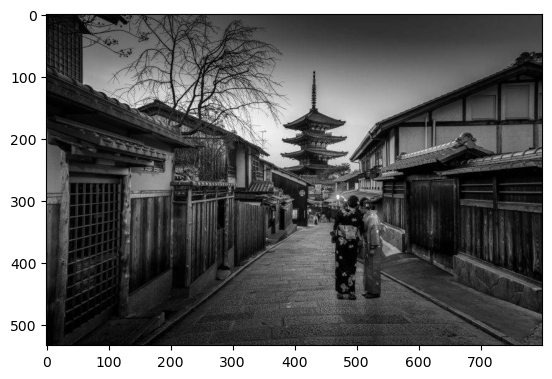

Range: 0.000000 - 1.000000 
Resolution:  (208, 242)


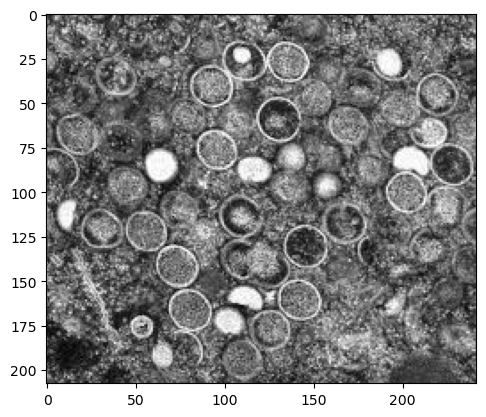

Range: 0.024096 - 1.000000 
Resolution:  (561, 996)


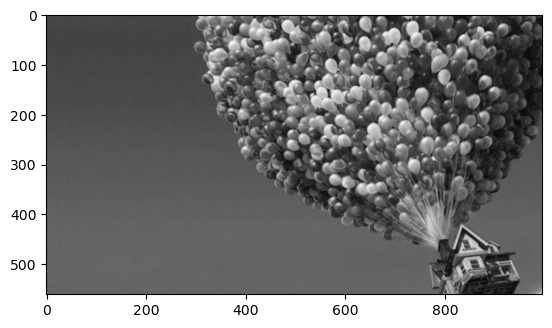

Range: 0.000000 - 1.000000 
Resolution:  (534, 800)


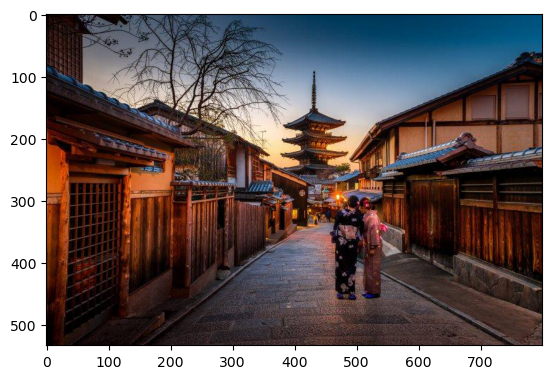

Range: 0.000000 - 1.000000 
Resolution:  (208, 242)


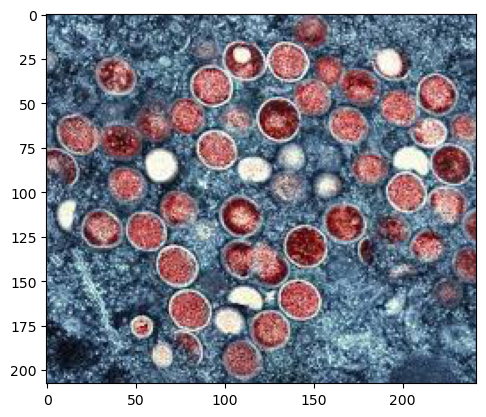

Range: 0.000000 - 1.000000 
Resolution:  (561, 996)


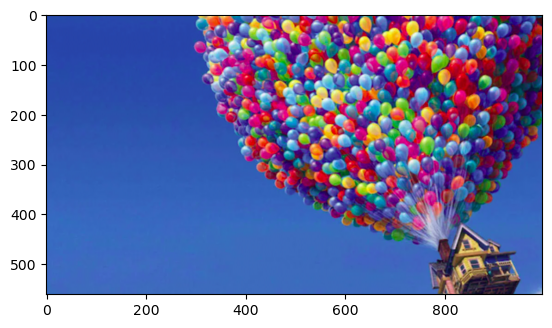

In [16]:
def Gaussian_Filters_v2(sigma): 
    n = int(np.ceil(3*sigma)*2 + 1)
    
    Gaussian_1D = cv2.getGaussianKernel(n,sigma)
    Gaussian = Gaussian_1D @ Gaussian_1D.T
    
    # n = np.linspace(-(n//2),n//2,n)
    
    # x,y = np.meshgrid(n,n)
    
    # Gaussian_byHand = (1/(2*np.pi*np.square(sigma)))*np.exp(-(x**2 + y**2)/(2*sigma**2)) 
    # LoG = ((x**2 + y**2 - 2*sigma**2)/(2*np.pi*sigma**6))*np.exp(-(x**2 + y**2)/(2**np.square(sigma))) 
    
    return Gaussian



# load Image cases grayscale

I_cells = cv2.imread('cells.jpg', cv2.IMREAD_GRAYSCALE)
I_up = cv2.imread('up.png', cv2.IMREAD_GRAYSCALE)
I_kyoto = cv2.imread('kyoto_edges.jpg', cv2.IMREAD_GRAYSCALE)

# Load colored images

I_cells_color = cv2.imread('cells.jpg')
I_up_color = cv2.imread('up.png') 
I_kyoto_color = cv2.imread('kyoto_edges.jpg')

# Convert colored from BGR to RGB
I_cells_color = cv2.cvtColor(I_cells_color, cv2.COLOR_BGR2RGB)
I_up_color = cv2.cvtColor(I_up_color, cv2.COLOR_BGR2RGB)
I_kyoto_color = cv2.cvtColor(I_kyoto_color, cv2.COLOR_BGR2RGB)

# Normalizations

I_cells = I_cells.astype(float)/255
I_up = I_up.astype(float)/np.max(I_up)
I_kyoto = I_kyoto.astype(float)/255

I_cells_color = I_cells_color.astype(float)/255
I_up_color = I_up_color.astype(float)/np.max(I_up_color)
I_kyoto_color = I_kyoto_color.astype(float)/255

print("Range: %f - %f " % (np.min(I_kyoto), np.max(I_kyoto)))
print("Resolution: ", I_kyoto.shape)
plt.imshow(I_kyoto, cmap='gray')
plt.show()

print("Range: %f - %f " % (np.min(I_cells), np.max(I_cells)))
print("Resolution: ", I_cells.shape)
plt.imshow(I_cells, cmap='gray')
plt.show()

print("Range: %f - %f " % (np.min(I_up), np.max(I_up)))
print("Resolution: ", I_up.shape)
plt.imshow(I_up, cmap='gray')
plt.show()

print("Range: %f - %f " % (np.min(I_kyoto_color), np.max(I_kyoto_color)))
print("Resolution: ", I_kyoto.shape)
plt.imshow(I_kyoto_color)
plt.show()

print("Range: %f - %f " % (np.min(I_cells_color), np.max(I_cells_color)))
print("Resolution: ", I_cells.shape)
plt.imshow(I_cells_color)
plt.show()

print("Range: %f - %f " % (np.min(I_up_color), np.max(I_up_color)))
print("Resolution: ", I_up.shape)
plt.imshow(I_up_color)
plt.show()

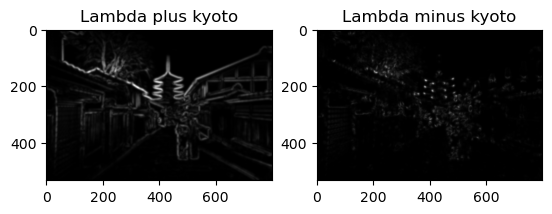

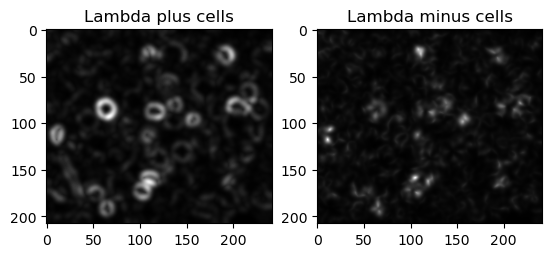

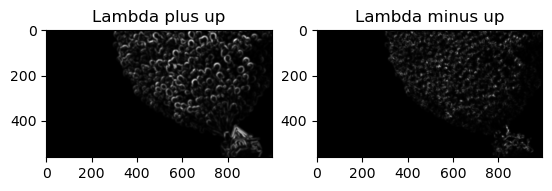

In [29]:
# Compute tensor J elements

k = 0.1
sigma = 2
ro = 2.5

def J_generate(Im, sigma, ro):
    
    Gaussian_sigma = Gaussian_Filters_v2(sigma)
    Gaussian_ro = Gaussian_Filters_v2(ro)
    
    Im_sigma = cv2.filter2D(Im,-1,Gaussian_sigma)
    
    Grad_y_x = np.gradient(Im_sigma)
    Grad_y = Grad_y_x[0]
    Grad_x = Grad_y_x[1]
    
    J1 = cv2.filter2D((Grad_x*Grad_x),-1,Gaussian_ro)
    J2 = cv2.filter2D((Grad_x*Grad_y),-1,Gaussian_ro)
    J3 = cv2.filter2D((Grad_y*Grad_y),-1,Gaussian_ro)
    
    return J1, J2, J3

def J_eigenvalues(J1,J2,J3):
    lamda_plus = 0.5*(J1 + J3 + np.sqrt((J1-J3)**2 + 4*J2**2))
    lamda_minus = 0.5*(J1 + J3 - np.sqrt((J1-J3)**2 + 4*J2**2))
    
    return lamda_plus, lamda_minus

# Computing eigenvalues

J1, J2, J3 = J_generate(I_kyoto, sigma, ro)
lamda_plus_kyoto, lamda_minus_kyoto = J_eigenvalues(J1, J2, J3)

J1, J2, J3 = J_generate(I_cells,  sigma, ro)
lamda_plus_cells, lamda_minus_cells = J_eigenvalues(J1, J2, J3)

J1, J2, J3 = J_generate(I_up, sigma, ro)
lamda_plus_up, lamda_minus_up = J_eigenvalues(J1, J2, J3)

# Plotting Eigenvalues

plt.subplot(1,2,1)
plt.imshow(lamda_plus_kyoto, cmap='gray')
plt.title("Lambda plus kyoto")
plt.subplot(1,2,2)
plt.imshow(lamda_minus_kyoto, cmap='gray')
plt.title("Lambda minus kyoto")
plt.savefig('fig7.jpg')
plt.show()

plt.subplot(1,2,1)
plt.imshow(lamda_plus_cells, cmap='gray')
plt.title("Lambda plus cells")
plt.subplot(1,2,2)
plt.imshow(lamda_minus_cells, cmap='gray')
plt.title("Lambda minus cells")
plt.savefig('fig8.jpg')
plt.show()

plt.subplot(1,2,1)
plt.imshow(lamda_plus_up, cmap='gray')
plt.title("Lambda plus up")
plt.subplot(1,2,2)
plt.imshow(lamda_minus_up, cmap='gray')
plt.title("Lambda minus up")
plt.savefig('fig9.jpg')
plt.show()

In [30]:
# Cornerness criterion

def R_gen(lamda_plus, lamda_minus, k):
    return (lamda_plus*lamda_minus - k*(lamda_plus+lamda_minus)**2)

def Corners_gen(R, sigma, theta_corn):
    '''
    This function returns the corresponding image Corners in format appropriate to feed interest_points_visualization
    
    '''
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = ( R==cv2.dilate(R,B_sq) )
    
    Cond2 = (R > theta_corn*np.max(R))
    
    Corners_y_x = (Cond1 & Cond2)
    
    indices_tuples = np.where(Corners_y_x == 1)
    
    scale = sigma*np.ones((np.size(indices_tuples[0])))
    
    Corners = list(zip(indices_tuples[1],indices_tuples[0],scale))
    
    return np.asarray(Corners)

R_kyoto = R_gen(lamda_plus_kyoto,lamda_minus_kyoto,k)
Corners_kyoto = Corners_gen(R_kyoto,sigma,0.05)

print(Corners_kyoto.shape)

R_cells = R_gen(lamda_plus_cells,lamda_minus_cells,k)
Corners_cells = Corners_gen(R_cells,sigma,0.05)

print(Corners_cells.shape)

R_up = R_gen(lamda_plus_up,lamda_minus_up,k)
Corners_up = Corners_gen(R_up,sigma,0.05)

print(Corners_up.shape)

(59, 3)
(22, 3)
(223, 3)


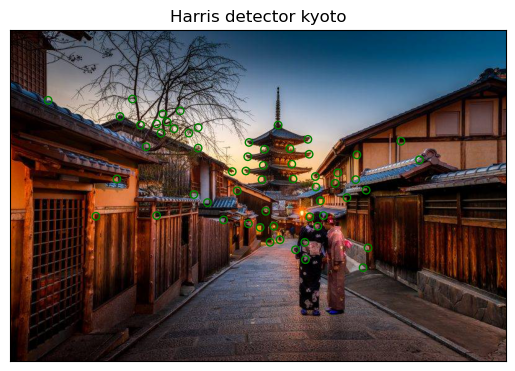

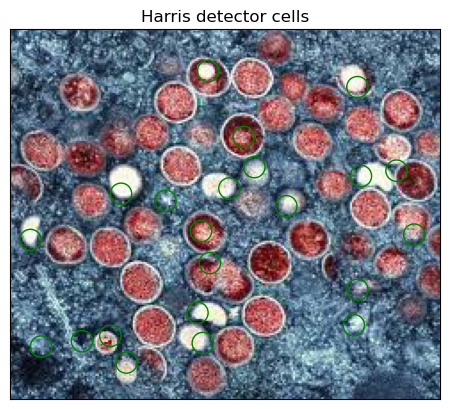

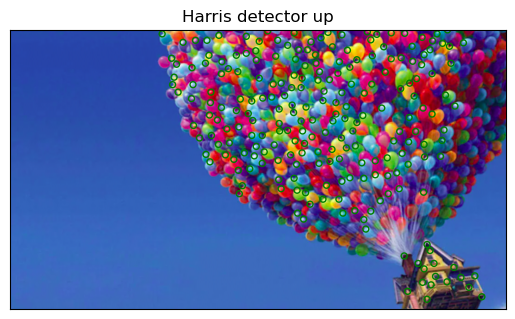

In [39]:
# Interest points visualization
%matplotlib inline

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Harris detector kyoto")
interest_points_visualization(I_kyoto_color, Corners_kyoto,ax)
ax.figure.savefig('fig10.jpg')

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Harris detector cells")
interest_points_visualization(I_cells_color, Corners_cells, ax)
ax.figure.savefig('fig11.jpg')

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Harris detector up")
interest_points_visualization(I_up_color, Corners_up, ax)
ax.figure.savefig('fig12.jpg')


2.2

In [14]:
# We integrated this function with interest_points to avoid repetition

# Compute Image Grads using Box Filters 

from numpy import floor

def grads_Box_Filters(Im,sigma):
    
    I = Integral_Im(Im)
    
    def box_response(y, x, dimy, dimx):
        return I[y - dimy//2][x - dimx//2] + I[y + dimy//2][x + dimx//2] - I[y - dimy//2][x + dimx//2] - I[y + dimy//2][x - dimx//2]
                
    n = np.ceil(3*sigma)*2+1
    
    num = int(floor(n/6))
    
    # Zero-pad the image
    
    dim2 = 2*num + 1
    dim1 = 4*num + 1
    
    Lxx = np.zeros((Im.shape[0],Im.shape[1]))
    Lyy = np.zeros((Im.shape[0],Im.shape[1]))
    Lyx = np.zeros((Im.shape[0],Im.shape[1]))
    
    for y in range(3*dim2//2, Im.shape[0] - 3*dim2//2):
        for x in range(3*dim2//2, Im.shape[1] - 3*dim2//2):
            Lxx[y][x] = box_response(y, x - dim2, dim1, dim2) - 2*box_response(y, x, dim1, dim2) + box_response(y, x + dim2, dim1, dim2)
            Lyy[y][x] = box_response(y - dim2, x, dim2, dim1) - 2*box_response(y, x, dim2, dim1) + box_response(y + dim2, x, dim2, dim1)
            Lyx[y][x] = box_response(y - dim2//2 - 1, x - dim2//2 - 1, dim2, dim2) - box_response(y - dim2//2 - 1, x + dim2//2 + 1, dim2, dim2) \
                        - box_response(y + dim2//2 + 1, x - dim2//2 - 1, dim2, dim2) + box_response(y + dim2//2 + 1, x + dim2//2 + 1, dim2, dim2)
            
    return Lxx, Lyy, Lyx
    

In [41]:
def scales(sigma_0, ro_0, s, N):
    
    final = [(sigma_0*(s**i), ro_0*(s**i)) for i in range(N)]
    
    return final


def grads(img):
    
    Grad_y_x = np.gradient(img)
    Grad_y = Grad_y_x[0]
    Grad_x = Grad_y_x[1]
            
    grad2_y_x = np.gradient(Grad_y)
    gradyy = grad2_y_x[0] # 2nd order deriv. in respect to y
    gradyx = grad2_y_x[1] # merikh ws pros y kai meta ws pros x
            
    grad3_y_x = np.gradient(Grad_x)
    gradxx = grad3_y_x[1] # 2nd order deriv. in respect to x
    
    return gradyy, gradxx, gradyx

 
def R_hessian(img, sigma): # for 2.3
    
    Gaussian_sigma = Gaussian_Filters_v2(sigma)
    Im_sigma = cv2.filter2D(img,-1,Gaussian_sigma)
    gradyy, gradxx, gradyx = grads(Im_sigma)
    
    return (gradyy*gradxx - (gradyx**2))



def interest_points (scales_arr, img, theta_corn, k, flag):
    '''
    This function computes all of the intrest points of an image at different scales
    
    scales_arr: list with the different scale (sigma, ro) tuples
    img: image case
    theta_corn: defines one of the cornerness cases
    flag: kathorizei to pws ypologizetai o pinakas R, eite mesw tou tropou sto 2.1 , eite mesw ths Hessian orizousas sto 2.3,
          eite me Box Filters sto 2.5.
    '''
    
    lista = []
    
    if flag == 0: 
        
        for i in range(len(scales_arr)): 
        
            sigma = scales_arr[i][0]
            ro = scales_arr[i][1]
    
            J1, J2, J3 = J_generate(img,sigma,ro)
            lamda_plus, lamda_minus = J_eigenvalues(J1,J2,J3)
            R = R_gen(lamda_plus,lamda_minus,k)
            corners = Corners_gen(R,sigma,theta_corn) 
            lista.append(corners)
        
    elif flag==1:
        
        for i in range(len(scales_arr)): 
        
            sigma = scales_arr[i][0]
            R = R_hessian(img, sigma)
            corners = Corners_gen(R,sigma,theta_corn) 
            lista.append(corners)
            
    else:
        for i in range(len(scales_arr)): 
            
            sigma = scales_arr[i][0]
            Lxx, Lyy, Lyx = grads_Box_Filters(img,sigma)
            R_box = Lxx*Lyy - (0.9*Lyx)**2
            corners = Corners_gen(R_box,sigma,theta_corn) 
            lista.append(corners)
    
    return lista


def img_log(img, sigma):
    
    Gaussian_sigma = Gaussian_Filters_v2(sigma)
    Im_sigma = cv2.filter2D(img,-1,Gaussian_sigma)
    
    gradyy, gradxx, gradyx = grads(Im_sigma)
        
    return (sigma**2)*np.abs(gradyy + gradxx)
    

def final_points(img, sigma_0, ro_0, s, N, theta_corn, k, flag):
    '''
    This function returns the final interest points of the multiscale analysis 
    after the Harris-Laplacian filtering criterion
    
    '''
    
    klimakes = scales(sigma_0, ro_0, s, N)
    nominees = interest_points(klimakes, img, theta_corn, k, flag) #ola ta ypopsifia shmeia gia kathe klimaka
    
    final = []
    
    LoG = [img_log(img,klimakes[i][0]) for i in range(N)]

    for i in range(N): # scales
        
        for j in range(nominees[i].shape[0]): # Points

            y = int(nominees[i][j][0])
            x = int(nominees[i][j][1])
            z = nominees[i][j][2] # to z symvolizei thn klimaka edw

            if(i == 0):

                if(LoG[0][x][y] > LoG[1][x][y]):
                    my_tuple = (y,x,z)
                    final.append(my_tuple)       
            
            elif (i == N-1):
            
                if(LoG[N-1][x][y] > LoG[N-2][x][y]):
                    my_tuple = (y,x,z)
                    final.append(my_tuple)
            
            else:
            
                if((LoG[i][x][y] > LoG[i+1][x][y]) & (LoG[i][x][y] > LoG[i-1][x][y])):
                    my_tuple = (y,x,z)
                    final.append(my_tuple)
    
    return np.asarray(final)


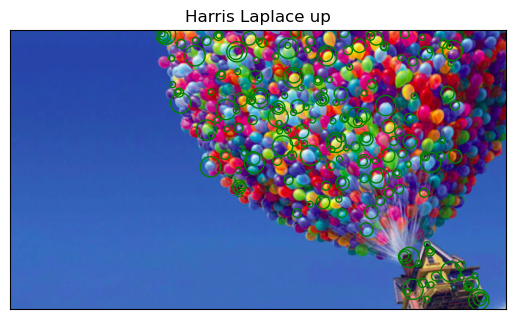

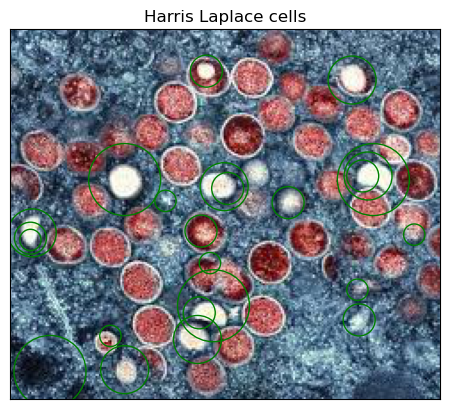

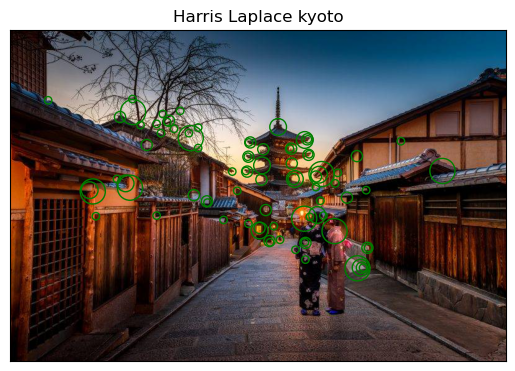

In [43]:
up_final = final_points(I_up, 2, 2.5, 1.5, 4, 0.05, 0.1, 0)
cells_final = final_points(I_cells, 2, 2.5, 1.5, 4, 0.05, 0.1, 0)
kyoto_final = final_points(I_kyoto, 2, 2.5, 1.5, 4, 0.05, 0.1, 0)  # de zhteitai to kyoto, apla to dokimasa

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Harris Laplace up")
interest_points_visualization(I_up_color, up_final, ax)
ax.figure.savefig('fig13.jpg')

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Harris Laplace cells")
interest_points_visualization(I_cells_color, cells_final, ax)
ax.figure.savefig('fig14.jpg')

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Harris Laplace kyoto")
interest_points_visualization(I_kyoto_color, kyoto_final, ax)
ax.figure.savefig('fig15.jpg')

2.3

In [45]:
R_hes_up = R_hessian(I_up, 2)
R_hes_cells = R_hessian(I_cells, 2)

Corners_up_hes = Corners_gen(R_hes_up, 2, 0.05)
Corners_cells_hes = Corners_gen(R_hes_cells, 2, 0.05)

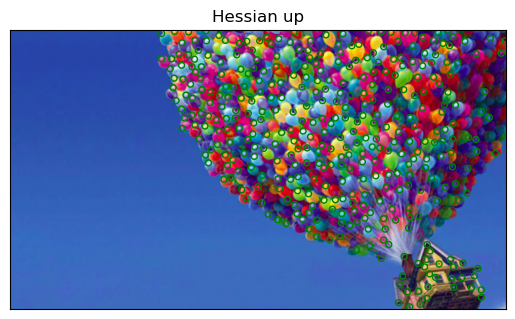

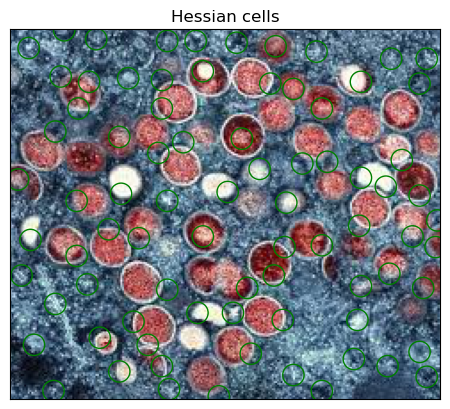

In [47]:
fig = plt.figure()
ax = fig.subplots()
ax.set_title("Hessian up")
interest_points_visualization(I_up_color, Corners_up_hes, ax)
ax.figure.savefig('fig16.jpg')

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Hessian cells")
interest_points_visualization(I_cells_color, Corners_cells_hes, ax)
ax.figure.savefig('fig17.jpg')

2.4

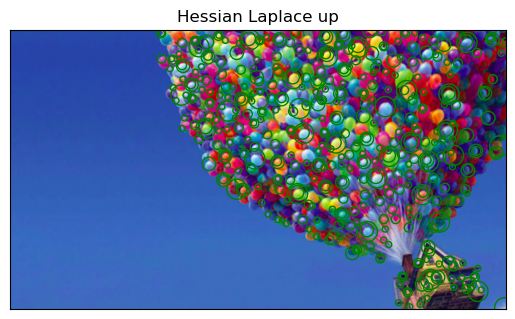

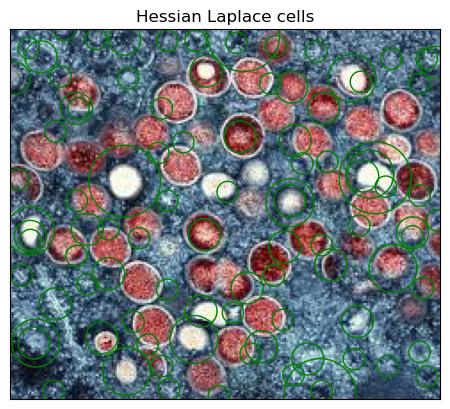

In [48]:
up_final_blobs = final_points(I_up, 2, 2.5, 1.5, 4, 0.05, 0.1, 1)

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Hessian Laplace up")
interest_points_visualization(I_up_color, up_final_blobs, ax)
ax.figure.savefig('fig18.jpg')

cells_final_blobs = final_points(I_cells, 2, 2.5, 1.5, 4, 0.05, 0.1, 1)
fig = plt.figure()
ax = fig.subplots()
ax.set_title("Hessian Laplace cells")
interest_points_visualization(I_cells_color, cells_final_blobs, ax)
ax.figure.savefig('fig19.jpg')

2.5

Resolution:  (534, 800)


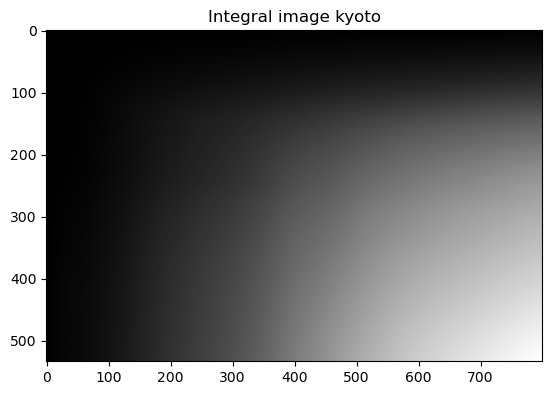

In [52]:
# Compute integral image

def Integral_Im(Im):
    Im_sum_y = np.cumsum(Im,axis=0)
    return np.cumsum(Im_sum_y,axis=1)

Integral_kyoto = Integral_Im(I_kyoto)

print("Resolution: ", Integral_kyoto.shape)
plt.imshow(Integral_kyoto, cmap='gray')
plt.title("Integral image kyoto")
plt.savefig('fig20.jpg')
plt.show()

In [53]:
# Compute Image Grads using Box Filters

from numpy import floor

def grads_Box_Filters(Im,sigma):
    
    I = Integral_Im(Im)
    
    def box_response(y, x, dimy, dimx):
        return I[y - dimy//2][x - dimx//2] + I[y + dimy//2][x + dimx//2] - I[y - dimy//2][x + dimx//2] - I[y + dimy//2][x - dimx//2]
                
    n = np.ceil(3*sigma)*2+1
    
    num = int(floor(n/6))
    
    # Zero-pad the image
    
    dim2 = 2*num + 1
    dim1 = 4*num + 1
    
    Lxx = np.zeros((Im.shape[0],Im.shape[1]))
    Lyy = np.zeros((Im.shape[0],Im.shape[1]))
    Lyx = np.zeros((Im.shape[0],Im.shape[1]))
    
    for y in range(3*dim2//2, Im.shape[0] - 3*dim2//2):
        for x in range(3*dim2//2, Im.shape[1] - 3*dim2//2):
            Lxx[y][x] = box_response(y, x - dim2, dim1, dim2) - 2*box_response(y, x, dim1, dim2) + box_response(y, x + dim2, dim1, dim2)
            Lyy[y][x] = box_response(y - dim2, x, dim2, dim1) - 2*box_response(y, x, dim2, dim1) + box_response(y + dim2, x, dim2, dim1)
            Lyx[y][x] = box_response(y - dim2//2 - 1, x - dim2//2 - 1, dim2, dim2) - box_response(y - dim2//2 - 1, x + dim2//2 + 1, dim2, dim2) \
                        - box_response(y + dim2//2 + 1, x - dim2//2 - 1, dim2, dim2) + box_response(y + dim2//2 + 1, x + dim2//2 + 1, dim2, dim2)
            
    return Lxx, Lyy, Lyx
    

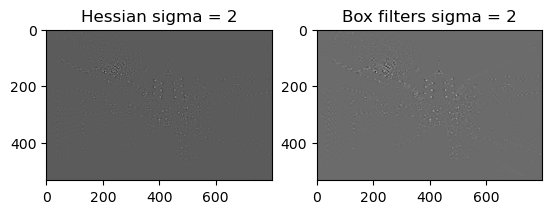

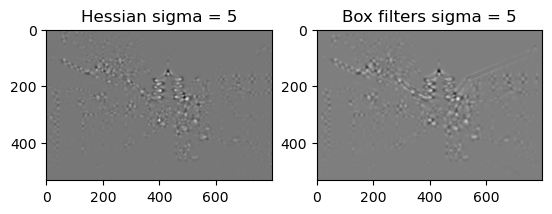

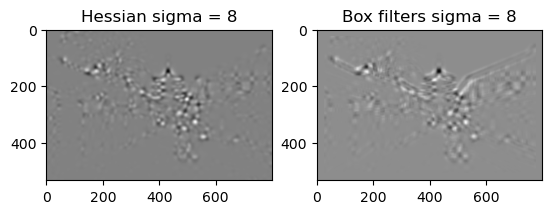

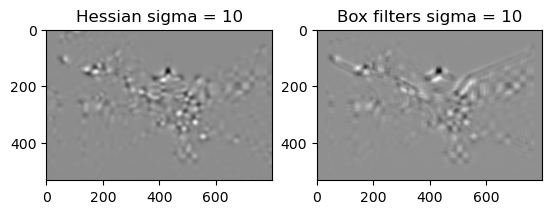

In [54]:
# Compute R

i = 0
for sigma in [2, 5, 8, 10]:
    i = i + 1
    R_Hess = R_hessian(I_kyoto,sigma)

    plt.subplot(1,2,1)
    plt.imshow(R_Hess, cmap='gray')
    plt.title("Hessian sigma = {}".format(sigma))

    Lxx, Lyy, Lyx = grads_Box_Filters(I_kyoto,sigma)

    R_box = Lxx*Lyy - (0.9*Lyx)**2

    plt.subplot(1,2,2)
    plt.imshow(R_box, cmap='gray')
    plt.title("Box filters sigma = {}".format(sigma))
    plt.savefig('fig{}.jpg'.format(20 + i))
    plt.show()

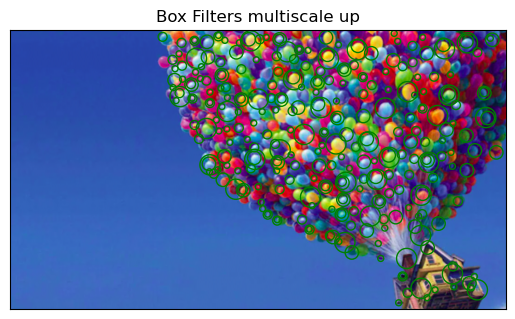

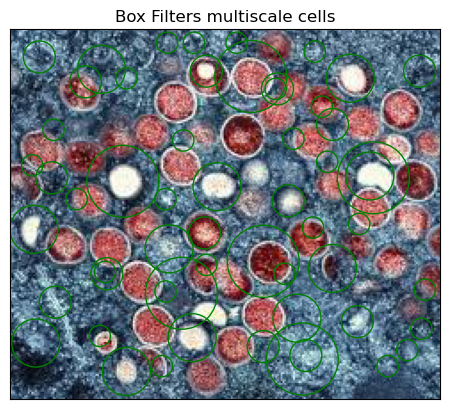

In [56]:
# Multiscale with Box Filters

up_final_blobs = final_points(I_up, 2, 2.5, 1.5, 4, 0.05, 0.1, 2)

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Box Filters multiscale up")
interest_points_visualization(I_up_color, up_final_blobs, ax)
ax.figure.savefig('fig25.jpg')

fig = plt.figure()
ax = fig.subplots()
ax.set_title("Box Filters multiscale cells")
cells_final_blobs = final_points(I_cells, 2, 2.5, 1.5, 4, 0.05, 0.1, 2)
interest_points_visualization(I_cells_color, cells_final_blobs, ax)
ax.figure.savefig('fig26.jpg')

-----

**Μέρος 3**

3.1

In [24]:
# Our single scale interest points detectors

def harrisDetector(I, sigma, ro, theta_corn, k):
    
    J1, J2, J3 = J_generate(I,sigma,ro)
    lamda_plus, lamda_minus = J_eigenvalues(J1,J2,J3)
    R = R_gen(lamda_plus,lamda_minus,k)
    Corners = Corners_gen(R,sigma,theta_corn) 
    
    return np.asarray(Corners)

def hessianDetector(I, sigma, theta_corn):
    
    R = R_hessian(I, sigma)
    Corners = Corners_gen(R,sigma,theta_corn) 
    
    return np.asarray(Corners)

def boxFiltersDetector(I, sigma, theta_corn):
    
    Lxx, Lyy, Lyx = grads_Box_Filters(I,sigma)
    R_box = Lxx*Lyy - (0.9*Lyx)**2
    Corners = Corners_gen(R_box,sigma,theta_corn) 
    
    return np.asarray(Corners)

In [25]:
import cv23_lab1_part3_utils as p3

In [26]:
# The detectors 
Detectors = [ lambda I: harrisDetector(I, 2, 2.5, 0.05, 0.1),
              lambda I: final_points(I, 2, 2.5, 1.5, 4, 0.05, 0.1, 0),
              lambda I: hessianDetector(I, 2, 0.05),
              lambda I: final_points(I, 2, 2.5, 1.5, 4, 0.05, 0.1, 1),
              lambda I: boxFiltersDetector(I, 2, 0.05)]

# to extract features (HOG/SURF).
Feature_extraction_funs = [lambda I, kp: p3.featuresSURF(I,kp), lambda I, kp: p3.featuresHOG(I,kp)]

In [27]:
detector_names = ['harrisDetector', 'harrisDetector multiscale', 'hessianDetector', 'hessianDetector multiscale', 'boxFiltersDetector']
feature_extraction_fun_names = ['SURF', 'HOG']

i = 0
for detector in Detectors:
    j = 0
    for feature_extraction_fun in Feature_extraction_funs:
        avg_scale_errors, avg_theta_errors = p3.matching_evaluation(detector, feature_extraction_fun)
        print('Detector {} and feature extraction method {}'.format(detector_names[i], feature_extraction_fun_names[j]))
        print('Avg. Scale Error for Image 1: {:.3f}'.format(avg_scale_errors[0]))
        print('Avg. Theta Error for Image 1: {:.3f}'.format(avg_theta_errors[0]))
        j = j+1
    i = i+1    


Detector harrisDetector and feature extraction method SURF
Avg. Scale Error for Image 1: 0.002
Avg. Theta Error for Image 1: 0.113
Detector harrisDetector and feature extraction method HOG
Avg. Scale Error for Image 1: 0.099
Avg. Theta Error for Image 1: 18.684
Detector harrisDetector multiscale and feature extraction method SURF
Avg. Scale Error for Image 1: 0.002
Avg. Theta Error for Image 1: 0.118
Detector harrisDetector multiscale and feature extraction method HOG
Avg. Scale Error for Image 1: 0.122
Avg. Theta Error for Image 1: 13.672
Detector hessianDetector and feature extraction method SURF
Avg. Scale Error for Image 1: 0.010
Avg. Theta Error for Image 1: 4.162
Detector hessianDetector and feature extraction method HOG
Avg. Scale Error for Image 1: 0.204
Avg. Theta Error for Image 1: 21.601
Detector hessianDetector multiscale and feature extraction method SURF
Avg. Scale Error for Image 1: 0.002
Avg. Theta Error for Image 1: 0.077
Detector hessianDetector multiscale and feature

3.2


In [28]:
Detectors = [lambda I: final_points(I, 2, 2.5, 1.5, 4, 0.05, 0.1, 0),
             lambda I: final_points(I, 2, 2.5, 1.5, 4, 0.05, 0.1, 1),
             lambda I: final_points(I, 2, 2.5, 1.5, 4, 0.05, 0.1, 2)]
        
Feature_extraction_funs = [lambda I, kp: p3.featuresSURF(I,kp), lambda I, kp: p3.featuresHOG(I,kp)]

detector_names = ['harrisDetector_multiscale', 'hessianDetector_multiscale', 'boxFiltersDetector_multiscale']
feature_extraction_fun_names = ['SURF', 'HOG']

i = 0
for detector in Detectors:
    j = 0
    for feature_extraction_fun in Feature_extraction_funs:
        feats = p3.FeatureExtraction(detector, feature_extraction_fun, saveFile = '{}_{}'.format(detector_names[i], feature_extraction_fun_names[j]))
        print('Detector {} and feature extraction method {} Done!'.format(detector_names[i], feature_extraction_fun_names[j]))
        j = j+1
    i = i+1

Time for feature extraction: 204.597
Detector harrisDetector_multiscale and feature extraction method SURF Done!
Time for feature extraction: 202.129
Detector harrisDetector_multiscale and feature extraction method HOG Done!
Time for feature extraction: 169.584
Detector hessianDetector_multiscale and feature extraction method SURF Done!
Time for feature extraction: 198.072
Detector hessianDetector_multiscale and feature extraction method HOG Done!
Time for feature extraction: 83.986
Detector boxFiltersDetector_multiscale and feature extraction method SURF Done!
Time for feature extraction: 101.691
Detector boxFiltersDetector_multiscale and feature extraction method HOG Done!


In [29]:
i = 0
for detector in Detectors:
    j = 0
    for feature_extraction_fun in Feature_extraction_funs:
        feats = p3.FeatureExtraction(detector, feature_extraction_fun, loadFile = '{}_{}'.format(detector_names[i], feature_extraction_fun_names[j]))
        accs = []
        for k in range(5):
            # Split into a training set and a test set.
            data_train, label_train, data_test, label_test = p3.createTrainTest(feats, k)
            # Perform Kmeans to find centroids for clusters.
            BOF_tr, BOF_ts = p3.BagOfWords(data_train, data_test)
            # Train an svm on the training set and make predictions on the test set
            acc, preds, probas = p3.svm(BOF_tr, label_train, BOF_ts, label_test)
            accs.append(acc)
        print('Detector {} and feature extraction method {} mean accuracy {:.3f}'.format(detector_names[i], feature_extraction_fun_names[j], 100.0*np.mean(accs)))
        j = j+1
    i = i+1

Detector harrisDetector_multiscale and feature extraction method SURF mean accuracy 57.793
Detector harrisDetector_multiscale and feature extraction method HOG mean accuracy 64.690
Detector hessianDetector_multiscale and feature extraction method SURF mean accuracy 57.793
Detector hessianDetector_multiscale and feature extraction method HOG mean accuracy 67.310
Detector boxFiltersDetector_multiscale and feature extraction method SURF mean accuracy 59.310
Detector boxFiltersDetector_multiscale and feature extraction method HOG mean accuracy 66.897


In [30]:
print(feats[0][7].shape)
print(data_train[7].shape)
print(BOF_tr.shape)

(114, 36)
(147, 36)
(337, 500)
